# MOSAIKS: Train and test example for a single task

This notebook provides a simple example of how a new user can leverage the MOSAIKS system to generate predictions of any new outcome. There are three steps: 

1) Merge labels (i.e. "ground truth") with corresponding MOSAIKS features, based on location

2) Train the prediction model using ridge regression and k-fold cross-validation

3) Show performance on the validation set of labeled data 

This example predicts population density throughout the United States, using labeled data from the Gridded Population of the World. It is designed to allow the user to easily replace this task with a new set of labeled data for a new outcome of interest.

## Methodology

The process involves the following steps:

1. **Data Acquisition:** Label data on internet access is provided by the Agence Togo Digital (ATD). Pre-processed satellite imagery features are derived using the MOSAIKS framework.
1. **Data Preprocessing:** The label and feature data are preprocessed and cleaned. This leaves a single dataset with labels and features that is ready to use.
1. **Model Training and Evaluation:** A machine learning model, specifically Ridge Regression with isotonic calibration, is trained on the joined dataset to predict the likelihood of internet access. The model is evaluated using metrics like the Receiver Operating Characteristic Area Under the Curve (ROC AUC).
1. **Visualization and Interpretation:** The model results are visualized using maps and plots. Important features identified by the model are analyzed to understand the patterns associated with internet access.


## Setup

This notebook utilizes several key Python libraries:

* **Data Handling and Analysis:**  `pandas` and `numpy` provide fundamental data structures and functions for manipulating and analyzing data. `geopandas` extends these capabilities to work with geospatial data.
* **Visualization:** `matplotlib.pyplot` and `seaborn` enable the creation of static and interactive visualizations, aiding in data exploration and result presentation.
* **Machine Learning:** `sklearn` offers a comprehensive suite of tools for building and evaluating machine learning models, including algorithms like Ridge Regression and methods for data preprocessing.

In [34]:
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# from google.colab import drive

from scipy.linalg import LinAlgWarning
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings(
    "ignore", category=LinAlgWarning, module="sklearn.linear_model._ridge"
)

## Download data

Text about sample data stored on Zenodo. 

In [2]:
data_dir = "rolf_et_al_2021_data"

if not os.path.exists(data_dir):
    !wget https://zenodo.org/records/14518415/files/Rolf_et_al_2021_CONT_US_UAR_Data.zip

    !unzip Rolf_et_al_2021_CONT_US_UAR_Data.zip

    !mv Rolf_et_al_2021_CONT_US_UAR_Data {data_dir}

    !rm Rolf_et_al_2021_CONT_US_UAR_Data.zip

!ls -lhR {data_dir}

rolf_et_al_2021_data:
total 17K
drwxr-xr-x 8 cullen_molitor emlab 8 Dec 18 11:37 applications
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:40 features

rolf_et_al_2021_data/applications:
total 291K
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:37 elevation
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:38 income
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:38 nightlights
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:38 population
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:39 roads
drwxr-xr-x 2 cullen_molitor emlab 3 Dec 18 11:39 treecover

rolf_et_al_2021_data/applications/elevation:
total 5.5M
-rw-r--r-- 1 cullen_molitor emlab 7.3M Dec 18 10:07 outcomes_sampled_elevation_CONTUS_16_640_UAR_100000_0.csv

rolf_et_al_2021_data/applications/income:
total 1.9M
-rw-r--r-- 1 cullen_molitor emlab 2.7M Dec 18 10:07 outcomes_sampled_income_CONTUS_16_640_UAR_100000_0.csv

rolf_et_al_2021_data/applications/nightlights:
total 4.1M
-rw-r--r-- 1 cullen_molitor emlab 5.1M Dec 18 10:10 outcomes_sam

## Load data

### Task-specific data

Here, the user will need to adjust `label` for their particular context. To run the `treecover` prediction, nothing should need to be updated. If the user is interested in a different task, they will need to update the object `label` to the new task name. Available tasks can be viewed by running the cell below.

In [61]:
!ls {data_dir}/applications

elevation  income  nightlights	population  roads  treecover


Select your task from the list of available tasks and update the `label` object accordingly.

In [ ]:
label = "treecover"

labels = pd.read_csv(
    os.path.join(
        data_dir,
        "applications",
        label,
        f"outcomes_sampled_{label}_CONTUS_16_640_UAR_100000_0.csv",
    )
)
labels = labels.drop(
    columns=["Unnamed: 0", "lon", "lat", "V1", "V1.1"], errors="ignore"
)
labels

,ID,treecover
0,"2078,3075",84.829767
1,"2119,3101",24.316364
2,"2145,3104",69.093228
3,"1968,3053",54.553953
4,"2230,3159",30.871985
...,...,...
99995,"913,231",56.053514
99996,"146,252",59.698125
99997,"240,144",90.418367
99998,"979,124",68.462105


### Random convolutional feature data

The random convolutional features are stored in a feather file. 



In [4]:
features = pd.read_feather(
    os.path.join(
        data_dir,
        "features",
        "CONTUS_UAR_4000.feather",
    )
)
features

,lon,lat,ID,X_0,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3990,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999
0,-82.33299,31.13310,"1825,3099",109.421745,0.002730,1.598002,0.051948,192.028061,0.0,0.042064,...,212.718689,0.019774,427.188171,0.108375,219.264877,0.551875,0.003141,287.808197,245.936935,179.252518
1,-120.93713,45.04865,"534,296",191.471115,0.000494,0.674733,0.033643,325.599121,0.0,0.018419,...,377.188477,0.001119,699.936096,0.068607,360.706421,0.871681,0.000591,450.409790,439.766113,253.609039
2,-101.39404,33.43802,"1627,1715",216.488083,0.000000,1.018798,0.007720,363.550476,0.0,0.012265,...,433.769012,0.002850,790.867004,0.116930,416.635193,0.255052,0.000000,480.654663,521.126648,249.919861
3,-106.09044,45.43651,"494,1374",176.507919,0.000000,1.139586,0.007526,305.683167,0.0,0.010535,...,354.299713,0.001619,717.276184,0.091212,385.545471,0.160233,0.000000,435.593903,441.569458,245.792343
4,-86.01023,44.06743,"634,2832",67.180176,0.012096,0.800398,0.032882,134.503418,0.0,0.033844,...,131.081009,0.026110,388.369141,0.097194,213.896362,0.480515,0.004966,257.275879,176.741394,189.037567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-105.40182,44.58954,"581,1424",188.133865,0.001997,4.124390,0.172895,321.569458,0.0,0.112080,...,373.564240,0.007939,713.957642,0.117884,373.920776,3.448401,0.010491,448.380646,446.624176,250.797180
99996,-110.99343,33.09257,"1657,1018",222.788437,0.000903,3.321170,0.175439,380.871429,0.0,0.043889,...,426.669647,0.001576,771.051392,0.041341,377.991425,2.073433,0.004342,546.509888,461.291199,332.397888
99997,-102.05512,38.90338,"1135,1667",246.027954,0.000077,0.805266,0.016228,412.352112,0.0,0.020553,...,489.502960,0.000432,878.196289,0.081718,457.287811,0.323063,0.000000,546.172119,577.277771,288.189545
99998,-78.84856,42.39192,"801,3352",118.577003,0.003373,1.552520,0.056660,223.619614,0.0,0.032953,...,230.661499,0.007898,580.112000,0.112625,311.864685,0.460987,0.005661,387.947998,289.495636,269.729645


## Merge labeled data with features by location

To generalize MOSAIKS across many tasks, we create a standardized grid onto which we project both satellite images and labeled training data. This grid is described in detail in Supplementary Materials Section S.2.1. As described in the Supplementary Materials, satellite images are extracted over the area of each grid cell, and corresponding features are created from each grid cell's imagery. Labeled data are averaged (or summed) over each grid cell.

We sample from this standardized grid in two ways: uniform-at-random (UAR) and population-weighted (POP). We draw 100,000 samples in each case, and the model is trained and all predictions are performed on this random sample. For the task of predicting population density, the sampling strategy we use is UAR, although the user can change this option in the config.py file.

Here, we merge satellite image-based features ("X") with labeled data ("Y") based on the location of the grid cell. This provides us with a training dataset in which each grid cell has both an outcome ("Y") and a corresponding vector of MOSAIKS features ("X").

To predict a new variable not predicted in the paper, the user will need to calculate grid cell labels from "ground-truth" measurements. These labels can then be merged onto the features. We show examples of how one might calculate these labels in the `code/analysis/label_creation/` section of the original [replication repository](https://github.com/Global-Policy-Lab/mosaiks-paper). 

In [5]:
merged_df = pd.merge(labels, features, on="ID")
merged_df

,ID,lon,lat,treecover,X_0,X_1,X_2,X_3,X_4,X_5,...,X_3990,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999
0,"2078,3075",-82.66353,28.10474,84.829767,78.549942,0.006089,1.132010,0.055586,141.958649,0.000233,...,152.680740,0.032413,333.256653,0.106739,173.521713,0.886243,0.004991,225.356583,180.601562,147.860703
1,"2119,3101",-82.30544,27.60552,24.316364,82.047157,0.010907,2.516766,0.085712,145.077240,0.000000,...,162.264359,0.058108,339.956299,0.814965,178.814331,0.512769,0.006549,217.452164,197.297012,131.920166
2,"2145,3104",-82.26413,27.28777,69.093228,95.664230,0.003188,1.905777,0.040836,175.770996,0.000000,...,187.807388,0.016015,440.228119,0.103871,235.551437,0.564769,0.002052,288.328705,233.670380,190.926132
3,"1968,3053",-82.96652,29.43259,54.553953,84.029457,0.008169,2.450435,0.135407,154.474701,0.000131,...,165.628891,0.031113,388.941528,0.248468,209.115417,0.842863,0.003140,252.259857,207.821716,166.194046
4,"2230,3159",-81.50664,26.24261,30.871985,117.902916,0.005579,1.055545,0.073148,211.352783,0.000000,...,225.733261,0.014247,477.283661,0.074187,241.837601,0.913880,0.001646,336.056702,256.006714,222.042801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,"913,231",-121.83234,41.24247,56.053514,129.190918,0.003297,12.336563,0.118592,227.597534,0.000092,...,256.595154,0.018942,532.095154,0.376216,282.587555,4.846823,0.012753,337.947296,312.420288,204.515182
99996,"146,252",-121.54312,48.69929,59.698125,74.979019,0.033525,2.982325,0.455857,135.988449,0.001405,...,141.758911,0.116933,304.515350,0.172850,151.041336,2.461641,0.047333,224.077362,155.130112,153.607590
99997,"240,144",-123.03054,47.83765,90.418367,86.537003,0.008313,2.014197,0.050416,165.036972,0.000000,...,166.475098,0.024358,430.564606,0.101965,229.061508,1.999572,0.008373,294.968903,206.514114,209.843491
99998,"979,124",-123.30599,40.55547,68.462105,115.086357,0.004505,4.460683,0.106518,208.523926,0.000000,...,222.532593,0.010955,491.534424,0.087324,255.417892,3.013166,0.009728,336.207672,261.914368,223.477020


## Train the model

### Define `X`'s and `y` for the task


In [64]:
feature_cols = [f"X_{i}" for i in range(4000)]

y_var = {"roads": "length", "nightlights": "y"}.get(label, label)

X = merged_df[feature_cols]
y = merged_df[y_var]

### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 2: Train MOSAIKS model

We use ridge regression to train a model to predict each outcome variable (i.e. "task") using the same set of MOSAIKS features. 

Within the training/validation sample, we choose the penalization parameter in ridge regression using k-fold cross-validation (here we choose 5 folds). The input vector of penalization parameters (lambdas) are listed in the config.py file (and can be adjusted by the user if desired). In most results, we show performance on the training/validation sample, although the test sample is used just once to assess performance of the trained model for each task (see Supplementary Materials Section S.2.6). Test set and validation set performance are nearly identical for each of the tasks we considered (Table S2). 

In [ ]:
alphas = np.logspace(-3, 3, base=10, num=9)
ridge = RidgeCV(alphas=alphas, scoring="r2", cv=5)

ridge.fit(X_train, y_train)


Best alpha: 1.0
Validation R2 performance 0.88
Test R2 performance 0.8971


# Step 3: Show performance test set

Here, we show how the MOSAIKS predictions compare to labeled data. We use the training/validation set to do so, using the regression weights from the best-performing model chosen in the cross-validation step above. 

First, we show a simple scatter plot of labeled data against predictions. Second, we show the spatial distribution of labels and predictions.

In [ ]:
y_pred = np.maximum(ridge.predict(X_test), 0)

y_pred = np.minimum(y_pred, 100)

r2 = r2_score(y_test, y_pred)

print(f"Best alpha: {ridge.alpha_}")
print(f"Validation R2 performance {ridge.best_score_:0.2f}")
print(f"Test R2 performance {r2:.4f}")

### Labeled data versus predictions

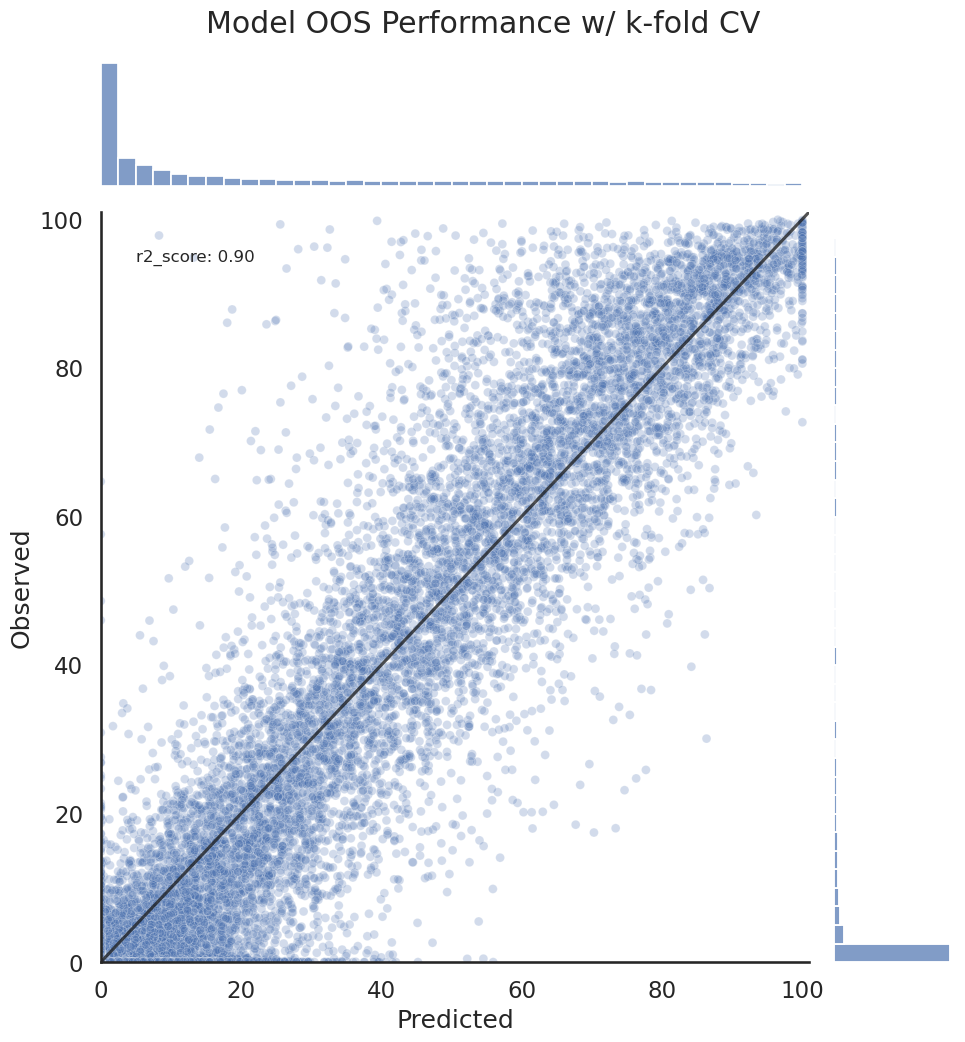

In [ ]:
r2 = r2_score(y_test, y_pred)

lims = (0, 101)

with sns.axes_style("white"):
    jg = sns.jointplot(
        x=y_pred,
        y=y_test,
        kind="scatter",
        height=10,
        xlim=lims,
        ylim=lims,
        size=10,
        alpha=0.25,
        legend=False,
        marginal_kws={"bins": 40, "alpha": 0.7},
    )

    # Add the 1:1 line
    jg.ax_joint.plot(lims, lims, "k-", alpha=0.75)

    # Set joint labels
    jg.ax_joint.set_xlabel("Predicted")
    jg.ax_joint.set_ylabel("Observed")

    # Add R² text
    jg.ax_joint.text(
        0.05,
        0.95,
        f"r2_score: {r2:.2f}",
        transform=jg.ax_joint.transAxes,
        fontsize=12,
        verticalalignment="top",
    )

    # Title (similar to performance_density)
    plt.suptitle("Model OOS Performance w/ k-fold CV", y=1.02)

    # Remove axis labels and ticks from marginal histograms
    jg.ax_marg_x.set_xlabel("")
    jg.ax_marg_x.set_ylabel("")
    jg.ax_marg_x.tick_params(axis="x", which="both", length=0)
    jg.ax_marg_x.tick_params(axis="y", which="both", length=0)
    jg.ax_marg_y.set_xlabel("")
    jg.ax_marg_y.set_ylabel("")
    jg.ax_marg_y.tick_params(axis="y", which="both", length=0)
    jg.ax_marg_y.tick_params(axis="x", which="both", length=0)

    # Optionally remove the spines around marginal histograms for a cleaner look
    sns.despine(ax=jg.ax_marg_x, left=True, bottom=True)
    sns.despine(ax=jg.ax_marg_y, left=True, bottom=True)

plt.show()


### Spatial distribution of observations and predictions

## Conclusions
This notebook demonstrated the use of MOSAIKS to predict Text

**Key Findings:**  

- Text

**Implications and Future Directions:**

- Text

**Limitations:**

- Text

Text